In [1]:
import dolfin as df 
from dolfin import *
import numpy as np
import os
from pymedit import (
    P1Function,
    square,
    mmg2d,
    trunc,
)

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
from scar.utils import read_config,create_tree,get_class
from scar.equations.run_EikonalLap2D import *
from scar.geometry import Geometry2D
from scar.geometry.StandardMesh import *
import torch
import dolfin as df
from dolfin import FunctionSpace,Function

import matplotlib.pyplot as plt

Using device: cuda
cuda devices:        1
cuda current device: 0
cuda device name:    NVIDIA RTX 2000 Ada Generation Laptop GPU
torch loaded; device is cuda
torch loaded; device is cuda


## Récupération de la Levelset

In [3]:
form_name = "Bean"
num_config = 3
sdf_run = run_EikonalLap2D

In [4]:
dir_name = "../../networks/EikonalLap2D/"+form_name+"/"
models_dir = dir_name+"models/"
config_filename = models_dir+"config_"+str(num_config)+".json"
model_filename = models_dir+"model_"+str(num_config)+".pth"
derivees_dir = dir_name+"derivees/"
create_tree(derivees_dir)

In [5]:
geom_class = get_class(form_name,Geometry2D)
form = geom_class()

bc_points.shape = (2000, 2), bc_normals.shape = (2000, 2)
MLP_x(
  (net): GenericMLP(
    (hidden_layers): ModuleList(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1-5): 5 x Linear(in_features=64, out_features=64, bias=True)
    )
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
    (activation_output): Id()
  )
)
>> load network /home/flecourtier/Bureau/Thèse/networks/EikonalLap2D/Bean/models/model_3.pth
jsbdbshd
network loaded


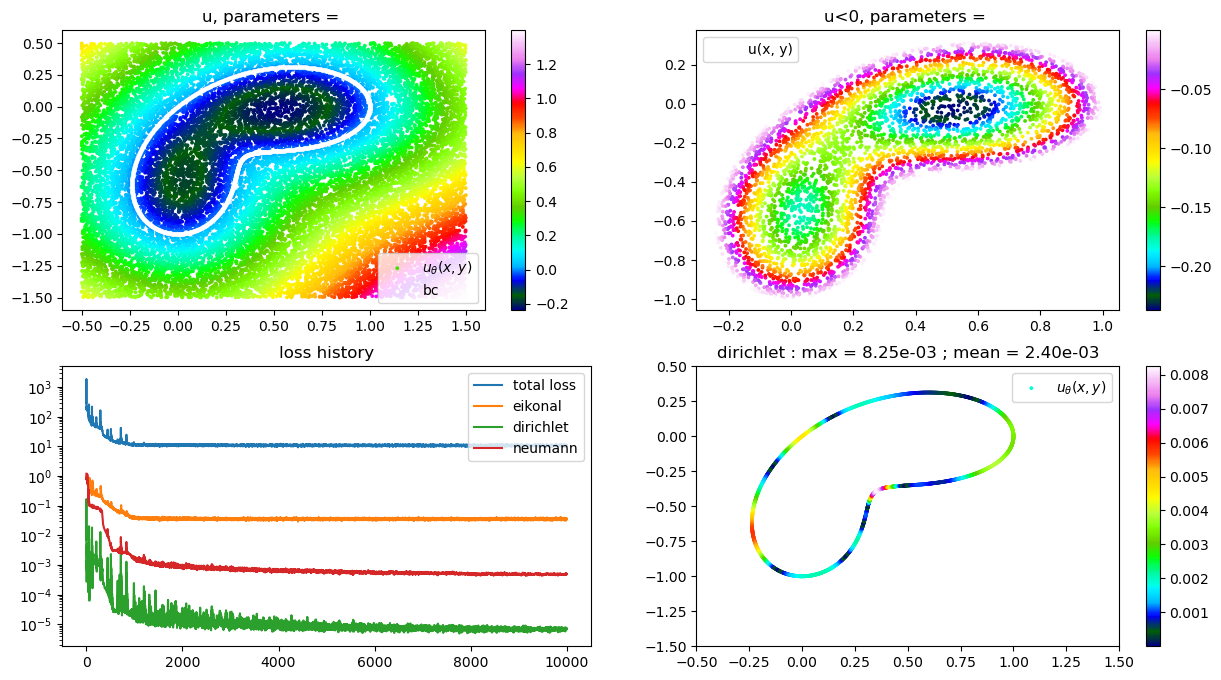

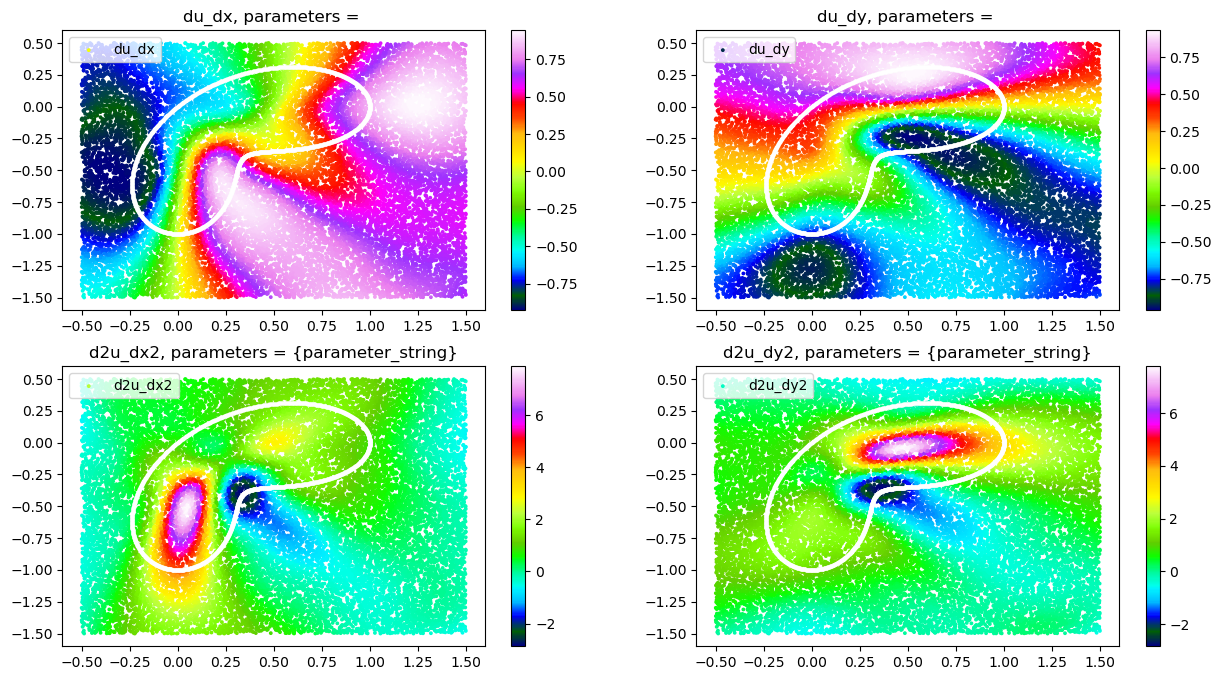

In [6]:
dict_config = read_config(config_filename)
eik,trainer = sdf_run(form,num_config,dict_config,new_training = False,createxyzfile=False)

## Construction du maillage standard

In [7]:
# mesh_dir = dir_name + "meshes/"
mesh_dir = "meshes/"
if not os.path.exists(mesh_dir):
    os.makedirs(mesh_dir)
mesh = standard_mesh(form,trainer,mesh_dir,0.01,0.05,n=201)

Reading new mesh from file


In [8]:
mesh.hmax()

0.13100498624847232

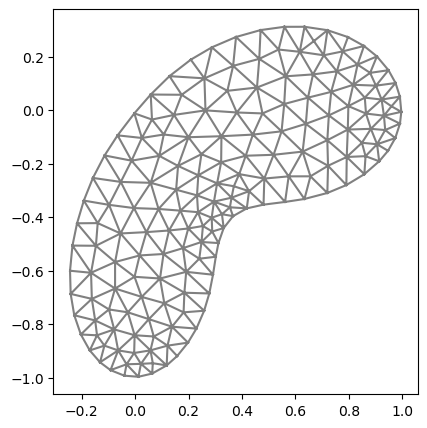

In [9]:
plt.figure(figsize=(5,5))
plot(mesh)

bc_points.shape = (2000, 2), bc_normals.shape = (2000, 2)
MLP_x(
  (net): GenericMLP(
    (hidden_layers): ModuleList(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1-5): 5 x Linear(in_features=64, out_features=64, bias=True)
    )
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
    (activation_output): Id()
  )
)
>> load network /home/flecourtier/Bureau/Thèse/networks/EikonalLap2D/Bean/models/model_2.pth
jsbdbshd
network loaded


AttributeError: 'Tensor' object has no attribute 'x'

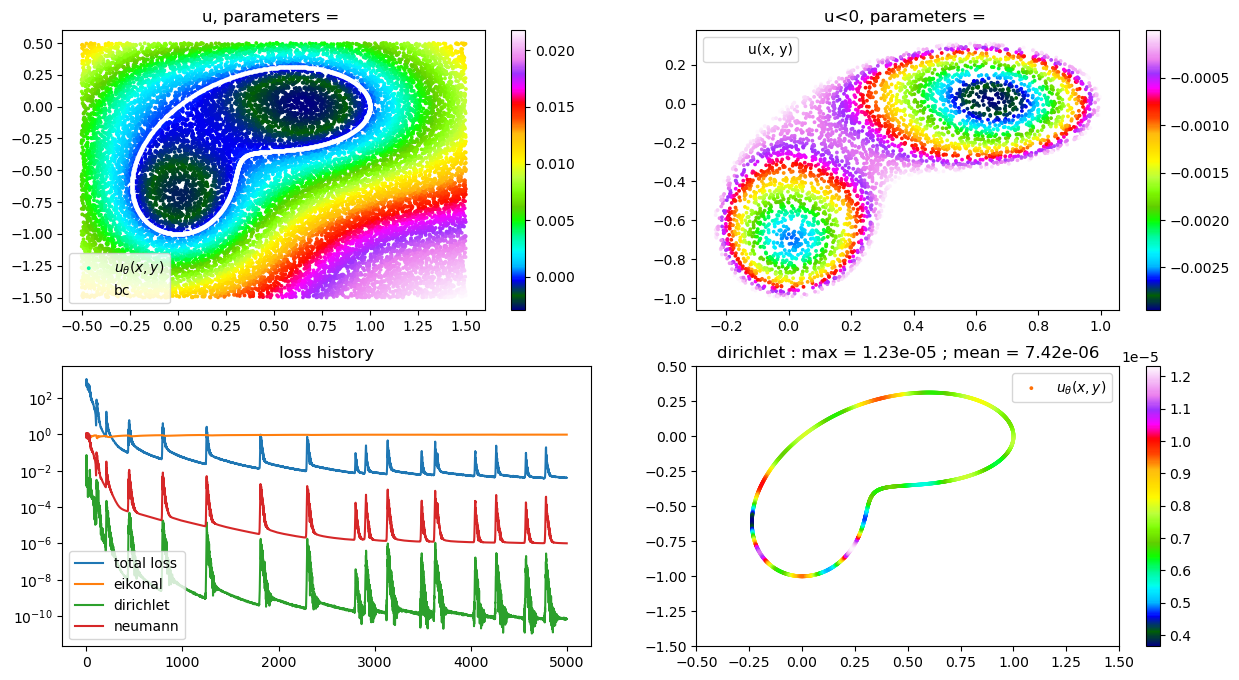

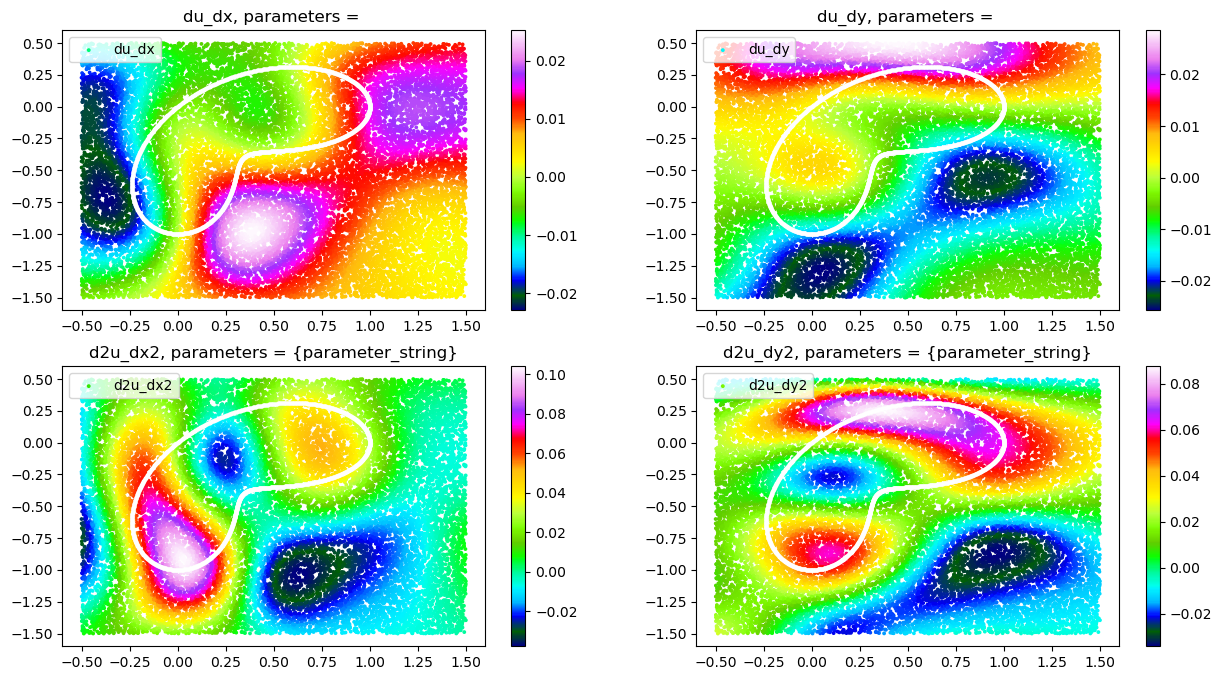

In [10]:
from scar.problem.Case import *
from scar.solver.solver_phifem import PhiFemSolver
config = 1
casefile = "../../testcases/"+"lap_bean_3.json"
casefile_dict = read_config(casefile)

cas = Case(casefile)
nb_vert = 10
phifem_solver = PhiFemSolver(nb_vert, params=[[]], cas=cas)

## Show boundary

In [10]:
approach_bc = get_boundary_vertices(mesh)
exact_bc = eik.bc_points.cpu().detach().numpy()

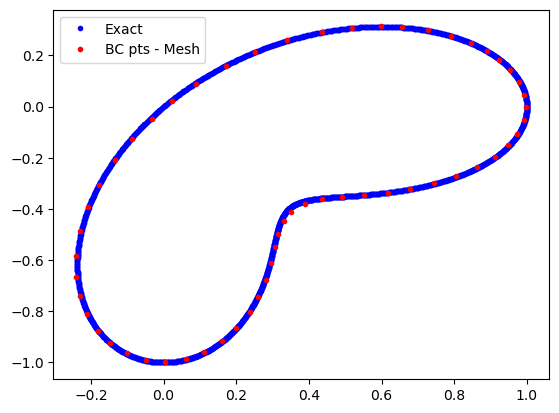

In [11]:
plt.figure()
plt.plot(exact_bc[:,0],exact_bc[:,1],'b.',label="Exact")
plt.plot(approach_bc[:,0],approach_bc[:,1],'r.',label="BC pts - Mesh")
plt.legend()
plt.show()

In [12]:
parameter_domain = trainer.pde.parameter_domain
X_test,mu_test = create_test_sample(approach_bc,parameter_domain)
pred = trainer.network.setup_w_dict(X_test, mu_test)
phi = pred["w"][:,0].cpu().detach().numpy()

In [13]:
print("Mean :",np.mean(np.abs(phi)))
print("Max :",np.max(np.abs(phi)))

Mean : 4.626641503091591e-05
Max : 0.00021881750560376334


## Convergence

In [14]:
tab_n = [20*i+1 for i in range(1,11)]
bc_error = []
for n in tab_n:
    parameter_domain = trainer.pde.parameter_domain
    XY = get_XY(form.bound_box,n)
    X_test,mu_test = create_test_sample(XY,parameter_domain)
    M,phiP1 = get_levelset(trainer,X_test,mu_test,n)

    hmin,hmax = 0.01,0.05
    filename = "levelset_mesh/"+form_name+"_"+str(n)
    if not os.path.exists(filename+".xml"):
        construct_mesh(M,phiP1,hmin,hmax,filename)
    mesh = get_df_mesh(form.bound_box,filename)

    approach_bc = get_boundary_vertices(mesh)
    exact_bc = eik.bc_points.cpu().detach().numpy()

    X_test,mu_test = create_test_sample(approach_bc,parameter_domain)
    pred = trainer.network.setup_w_dict(X_test, mu_test)
    phi = pred["w"][:,0].cpu().detach().numpy()

    bc_error.append(np.mean(np.abs(phi)))

Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file


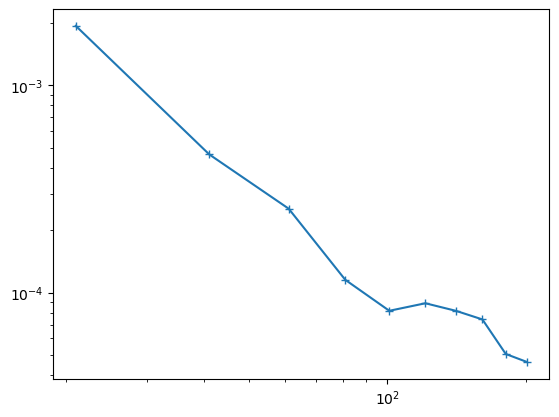

In [15]:
plt.figure()
plt.loglog(tab_n,bc_error,"+-")
plt.show()

In [16]:
tab_n = [20*i+1 for i in range(1,11)]
bc_error = []
for n in tab_n:
    parameter_domain = trainer.pde.parameter_domain
    XY = get_XY(form.bound_box,n)
    X_test,mu_test = create_test_sample(XY,parameter_domain)
    M,phiP1 = get_levelset(trainer,X_test,mu_test,n)

    hmin,hmax = 0.001,0.005
    filename = "levelset_mesh/"+form_name+"_"+str(n)+"_2"
    if not os.path.exists(filename+".xml"):
        construct_mesh(M,phiP1,hmin,hmax,filename)
    mesh = get_df_mesh(form.bound_box,filename)

    approach_bc = get_boundary_vertices(mesh)
    exact_bc = eik.bc_points.cpu().detach().numpy()

    X_test,mu_test = create_test_sample(approach_bc,parameter_domain)
    pred = trainer.network.setup_w_dict(X_test, mu_test)
    phi = pred["w"][:,0].cpu().detach().numpy()

    bc_error.append(np.mean(np.abs(phi)))

Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file
Reading new mesh from file


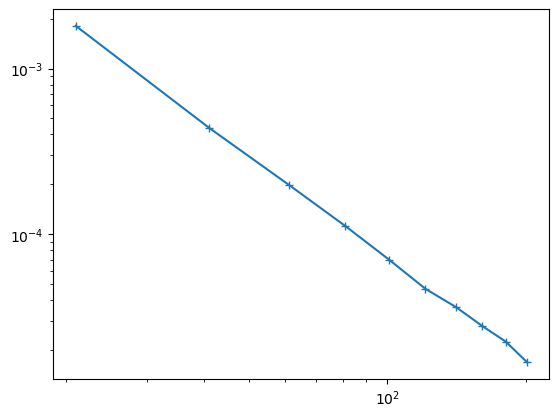

In [17]:
plt.figure()
plt.loglog(tab_n,bc_error,"+-")
plt.show()
